In [1]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%load_ext autoreload

In [2]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop


%matplotlib inline
dir_package = str(Path('./facebias').resolve())
if dir_package not in sys.path:
    print(f"adding {dir_package} to path")
    sys.path.append(dir_package)
else:
    print(dir_package)
from facebias.models.mlp import get_finetuned_mlp
from facebias.iotools import split_bfw_features

adding /Users/jrobby/WORK/src/facebias/code/facebias to path


In [3]:
font = {'font.family': 'serif',
        'font.serif' : 'Times New Roman',
        'font.color':  'darkred',
        'font.weight': 'normal',
        'font.size': 16,
        }
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_style('whitegrid', font)

In [4]:
d_input='../data/bfw/features/resnet50/features.pkl'
# d_input='../data/bfw/features/sphereface/features.pkl'

dir_features = str(Path(d_input).parent)
f_meta='../data/bfw/meta/bfw-fold-meta-lut.csv'
batch_size=64
do_gender=True
do_ethnicity=False
d_weights = 'train_models_resnet50/{}/'

# filenames of binary files (MLP weights)
fn_gender_weights = "gender_fc_model.h5"
fn_ethnicity_weights = "ethnicity_fc_model.h5"
NFOLDS=5

In [5]:
model = get_finetuned_mlp((1, 2048), optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## evaluate each fold

In [12]:
predictions, true_labels, true_refs = [], [], []
for fold in range(1, NFOLDS+1):
    print(f"Gender: fold {fold}")
    
    *_, ref_val, features_val, labels_val = split_bfw_features(f_meta, dir_features, val_fold=fold)
    model = get_finetuned_mlp(features_val.shape[1:], optimizer='adam')
    #     model.summary()
    
    path_in = Path(d_weights.format(fold)) / "gender_fc_model.h5"
    model.load_weights(str(path_in))
    pred = model.predict(features_val, verbose = 0) 
    predictions.append(pred)
    true_labels.append(labels_val)
    true_refs.append(ref_val)

Gender: fold 1
Gender: fold 2
Gender: fold 3
Gender: fold 4
Gender: fold 5


Print model summary

In [9]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_15 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

Compare predictions to ground-truth

In [46]:
scores = np.zeros((predictions[0].shape[0], NFOLDS))
counter = 0
for prediction, true_label in zip(predictions, true_labels):
    results = (np.round(prediction).flatten().astype(int) == np.round(true_label).flatten()).astype(int)
    scores[:, counter] = results.flatten()
    counter += 1
np.mean(scores, axis=0)

array([0.97525, 0.98325, 0.98525, 0.988  , 0.9795 ])

In [49]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [50]:
?confusion_matrix

Signature: confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array, shape = [n_samples]
    Ground truth (correct) target values.

y_pred : array, shape = [n_samples]
    Estimated targets as returned by a classifier.

labels : array, shape = [n_classes], optional
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
    If none is given, those that appear at least once
    in ``y_true`` or

In [119]:
from matplotlib import colors as colors, pyplot as plt, style as style, \
    ticker as mtick

from collections import defaultdict

In [121]:
label_lut = defaultdict()
label_lut['gender'] = {0: 'F', 1: 'M'}
label_lut['ethicity'] = {0: 'A', 1: 'B', 2: 'I', 3: 'W'}
print(label_lut)

defaultdict(None, {'gender': {0: 'F', 1: 'M'}, 'ethicity': {0: 'A', 1: 'B', 2: 'I', 3: 'W'}})


In [115]:
refs = [el.split('/')[0] for el in true_refs[0]]
refs_eth = [el.split('_')[0][0].upper() for el in refs]
refs_gender = [el.split('_')[1][0].upper() for el in refs]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
tags = le.fit_transform(refs_eth)
print(tags)
# str_tags = ['AF', 'AM', 'BF', 'BM', 'IF', 'IM', 'WF', 'WM']
str_tags = ['A', 'B', 'I', 'W']

[0 0 0 ... 3 3 3]


In [156]:
results = (np.round(predictions[0]).flatten().astype(int) == np.round(true_labels[0]).flatten()).astype(int)
true_label = true_labels[0]

df = pd.DataFrame([results, true_label, refs_gender, refs_eth])
df=df.T
df.columns=['yp', 'y', 'g', 'e']
df['tag'] = df.e + df.g
df.loc[:, 'yp'] = (df['yp'] - 1).abs() # flip labels so males are 1, females are 0.
df.head()
# df = pd.DataFrame([np.array(refs1).T, np.array(results).T], columns=['tag', 'indicator'])

,yp,y,g,e,tag
0,0,0,F,A,AF
1,0,0,F,A,AF
2,0,0,F,A,AF
3,0,0,F,A,AF
4,0,0,F,A,AF


In [132]:
df.groupby('tag').sum()['yp']

tag
AF    480
AM    493
BF    484
BM    489
IF    498
IM    491
WF    467
WM    499
Name: yp, dtype: int64

In [139]:
df.groupby('tag').sum()['yp']

tag
AF    480
AM    493
BF    484
BM    489
IF    498
IM    491
WF    467
WM    499
Name: yp, dtype: int64

Build image of scores to display as score map

In [133]:
heatmap = np.zeros((4, 4))

calculate gender classification accuracy for per ethnicity

In [196]:
tmp_df = df.copy()
tmp_df
conf_matrix = 1 - (df.groupby('e').sum()['yp'] /  df.groupby('e').count()['yp'])
# conf_matrix

heatmap[np.diag_indices_from(heatmap)] =conf_matrix.values*100

heatmap

array([[97.3,  0. ,  0. ,  0. ],
       [ 0. , 97.3,  0. ,  0. ],
       [ 0. ,  0. , 98.9,  0. ],
       [ 0. ,  0. ,  0. , 96.6]])

In [197]:
conf_matrix = (df.groupby('y').sum()['yp'] /  df.groupby('y').count()['yp'])
# conf_matrix=conf_matrix.reindex()/
# conf_matrix.index(str_tags)
# conf_matrix.loc[:,'tag'] = str_tags
# conf_matrix = confusion_matrix(predictions[0], true_labels[0], refs)
print(conf_matrix)

y
0    0.0355
1    0.0140
Name: yp, dtype: float64


In [198]:
tmp_df = df.copy()
tmp_tags = tmp_df.e.unique(), tmp_df.g.unique()
tmp_df['iscorrect'] = (tmp_df['y']==tmp_df['yp']).astype(int)
# for ethnicity in tmp_tags[0]:
#     indx = (tmp_df.e == ethnicity)
#     df_sliced = tmp_df.loc[indx]
    
# for gender in tmp_tags[1]:
# #     indx = (tmp_df.e == ethnicity) * 
#     indx=(tmp_df.g == gender)
#     df_sliced = tmp_df.loc[indx]
    
    
    
tmp_df.groupby('tag').sum()['iscorrect']/tmp_df.groupby('tag').count()['iscorrect']
# tmp_df.head()
# tmp_df.groupby('iscorrrect').sum()
# conf_matrix = (df_sliced.groupby('y').sum()['yp'] /  df_sliced.groupby('y').count()['yp'])

# conf_matrix
# conf_matrix = (df.groupby('e').sum()['yp'] /  df.groupby('e').count()['yp'])

tag
AF    0.960
AM    0.014
BF    0.968
BM    0.022
IF    0.996
IM    0.018
WF    0.934
WM    0.002
Name: iscorrect, dtype: float64

In [199]:
ids = np.tril_indices_from(heatmap), np.tril_indices_from(heatmap)
ids

((array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3]),
  array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3])),
 (array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3]),
  array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3])))

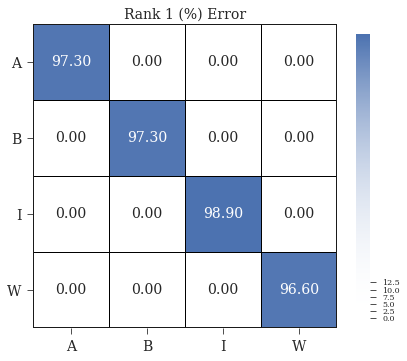

In [203]:
# plot confusion matrix in heatmap format
fig, ax = plt.subplots(figsize=(6, 6))

# set color scheme and style
cmap = colors.LinearSegmentedColormap.from_list(
    "nameofcolormap", ["w", "b"], gamma=2.0
)
style.use("seaborn-paper")  # sets the size of the charts
sns.set_style({"xtick.bottom": True}, {"ytick.left": True})

# plot heatmap using seaborn
ax = sns.heatmap(
    heatmap,
    annot=True,
    linewidths=0.1,
    square=True,
    cmap=cmap,
    cbar_kws={"shrink": 0.7, "ticks": [0.0, 2.5, 5.0, 7.5, 10.0, 12.5]},
    linecolor="black",
    ax=ax,
    fmt=".2f",
    annot_kws={"size": 14},
    cbar=True,
)

# add the column names as labels, set fontsize and set title
fontsize = 14
ax.set_yticklabels(tmp_tags[0], rotation=0, fontsize=fontsize)
ax.set_xticklabels(tmp_tags[0], fontsize=fontsize)
ax.axhline(y=0, color="k", linewidth=2)     
ax.axhline(y=heatmap.shape[1], color="k", linewidth=2)
ax.axvline(x=0, color="k", linewidth=2)
ax.axvline(x=heatmap.shape[0], color="k", linewidth=2)
ax.set_title("Rank 1 (%) Error", fontsize=fontsize)
plt.tight_layout()
plt.savefig('ethnicity_confusion.pdf')

In [180]:
?sns.heatmap

Signature:
sns.heatmap(
    data,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise they a

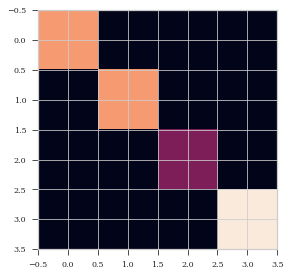

In [178]:
p(heatmap)
plt.show()

In [44]:
scores = np.zeros((predictions[0].shape[0], NFOLDS))
scores.shape
print(predictions[0].shape[0], NFOLDS)

4000 5


In [31]:
labels_val=labels_val[...,np.newaxis]

In [13]:
print(labels_val.shape)

(4000, 1)


In [14]:
pred1 = np.argmax(pred, axis = 1)[:5] 
label = np.argmax(labels_val,axis = 1)[:5] 

print(pred1)
print(label)

[0 0 0 0 0]
[0 0 0 0 0]


In [20]:
pred2 = np.argmax(pred, axis = 1)
import pandas as pd
df=pd.DataFrame(pred2.T, columns=['predictions'])
print(df.groupby('predictions').count())

Empty DataFrame
Columns: []
Index: [0]


In [22]:
df.max()

predictions    0
dtype: int64

In [ ]:
if do_ethnicity:
    for val_fold in range(1, N_FOLDS + 1):
        ref_tr, features_tr, labels_tr, ref_val, features_val, labels_val \
            = split_bfw_features(f_meta, dir_features, 'ethnicity')

        opt = Adam(lr=1e-4) if args.optimizer == 'adam' \
            else RMSprop(0.0001, decay=1e-6)
        model = get_finetuned_mlp(features_tr.shape[1:], optimizer=opt,
                                  loss='sparse_categorical_crossentropy',
                                  output_activation='softmax', output_size=4)

        model.fit(
            features_tr,
            labels_tr,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(features_val, labels_val),
            callbacks=[tb_callback]
        )
        path_in = path_weights / str(val_fold) / "ethnicity_fc_model.h5"
        model.save_weights(str(path_in))
